In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,45202,None,None,85804.592193
2020-06-13,45203,None,None,79695.281790
2020-06-14,45204,None,None,74029.572274
2020-06-15,45205,None,None,68691.421949
2020-06-16,45206,None,None,63934.466809
...,...,...,...,...
2021-04-03,45497,None,None,57930.228787
2021-04-04,45498,None,None,55209.929764
2021-04-05,45499,None,None,52426.960825


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-07_2021-04-07-16-32.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-06_2021-04-06-17-12.pickle


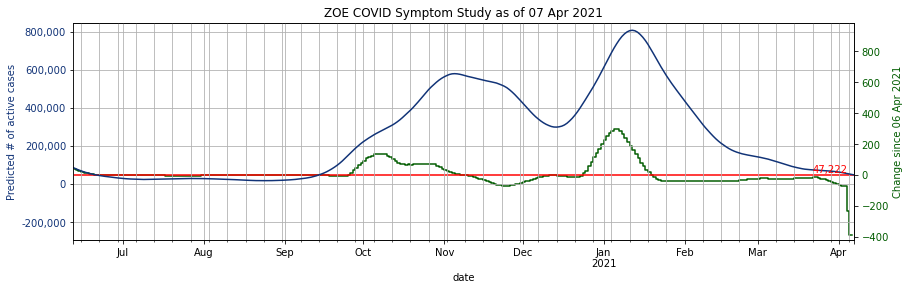

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

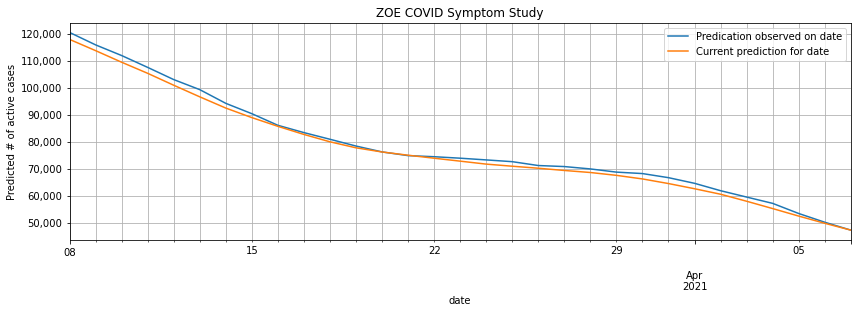

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-04-07_2021-04-07-16-32.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
376,South Lanarkshire,S12000029,0.627729
138,Taunton Deane,E07000190,0.534219
297,Falkirk,S12000014,0.404052
146,Staffordshire Moorlands,E07000198,0.364101
294,Walsall,E08000030,0.310570
285,South Tyneside,E08000023,0.306099
273,Trafford,E08000009,0.272562
351,Hillingdon,E09000017,0.267688
23,Bassetlaw,E07000171,0.262134
192,South Holland,E07000140,0.253231
